In [1]:
import os
import sys

import pandas as pd
import subprocess
import shlex


repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(repo_root)

from src.utils.file_handlers import group_dataset_files
from figure_settings.settings import * 
from src.utils.c_operation_helpers import run_simulation


In [2]:
EXPERIMENT_PATH = os.path.join(repo_root, 'exp', 'ex01')
# process_directory_c(EXPERIMENT_PATH)

### Example

In [3]:

data_dir = os.path.join(repo_root, 'datasets', 'Real_Data')

grouped = group_dataset_files(data_dir)

edge_file = grouped['00009']['edges']
node_file = grouped['00009']['nodes']
edge_path = os.path.join(data_dir, edge_file)
node_path = os.path.join(data_dir, node_file)


results = run_simulation(node_path, edge_path, .8, 1)
print(results)

    model   av_error       rho       tau     prior log-likelihood  \
0   HO_BT  0.0117834  0.999115   0.97572  -2.01461       -4.93014   
1  HOL_BT  0.0324929  0.993356  0.932977  -1.98163       -4.98081   
2     BIN  0.0131823  0.998876  0.972396   -2.0166       -4.93166   
3    BINL  0.0378141  0.991423  0.924332  -2.03393       -5.00218   

  leadership-log-likelihood iterations  
0                  -1.00688         11  
1                  -1.01106          8  
2                   -1.0071         10  
3                  -1.01283          8  


### Full Results

In [4]:
df = pd.read_csv(os.path.join(EXPERIMENT_PATH, 'results', 'log_likelihood_summary.csv'))
df.apply(pd.to_numeric, errors='ignore')


/tmp/ipykernel_80237/2248384130.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df.apply(pd.to_numeric, errors='ignore')


,HO_BT,HOL_BT,BIN,BINL,N,M,K,L,epoch
0,-10.39250,-13.79150,-10.41610,-14.94130,1000,29763,8,1,37
1,-6.32136,-8.35476,-6.33468,-8.59962,1000,100000,6,1,28
2,-6.30597,-8.31869,-6.31852,-8.58210,1000,100000,6,1,11
3,-0.44400,-0.44400,-0.44400,-0.44400,1000,11288,2,1,3
4,-2.09186,-2.15110,-2.09370,-2.16214,1000,23357,4,0,12
...,...,...,...,...,...,...,...,...,...
9995,-4.45750,-4.51669,-4.45893,-4.53224,1000,100000,6,0,29
9996,-3.01092,-3.41906,-3.02290,-3.67175,1000,6951,4,1,14
9997,-7.52047,-8.09815,-7.53782,-8.43653,1000,8858,8,0,6
9998,-3.32629,-3.21996,-3.39699,-3.35797,1000,1000,4,1,46


In [5]:
main = df.groupby(by=['N', 'M', 'K', 'L']).mean().reset_index().drop(columns=['epoch'])
print(main)

        N       M   K  L      HO_BT     HOL_BT        BIN       BINL
0    1000    1000   2  0  -0.633575  -0.633575  -0.633575  -0.633575
1    1000    1000   2  1  -0.635607  -0.635607  -0.635607  -0.635607
2    1000    1000   4  0  -2.546967  -2.771442  -2.579792  -2.817037
3    1000    1000   4  1  -3.386414  -3.227296  -3.484910  -3.380653
4    1000    1000   6  0  -5.093107  -5.824462  -5.210416  -6.042419
..    ...     ...  .. ..        ...        ...        ...        ...
195  1000  100000   6  1  -6.316503  -8.289058  -6.328875  -8.523568
196  1000  100000   8  0  -7.437947  -7.543153  -7.439228  -7.580503
197  1000  100000   8  1 -10.354926 -13.875566 -10.372444 -14.334020
198  1000  100000  10  0 -10.762122 -10.932024 -10.763500 -11.009554
199  1000  100000  10  1 -14.863124 -20.218574 -14.884940 -20.980992

[200 rows x 8 columns]


In [6]:
main['R'] = df['M'] / df['N']

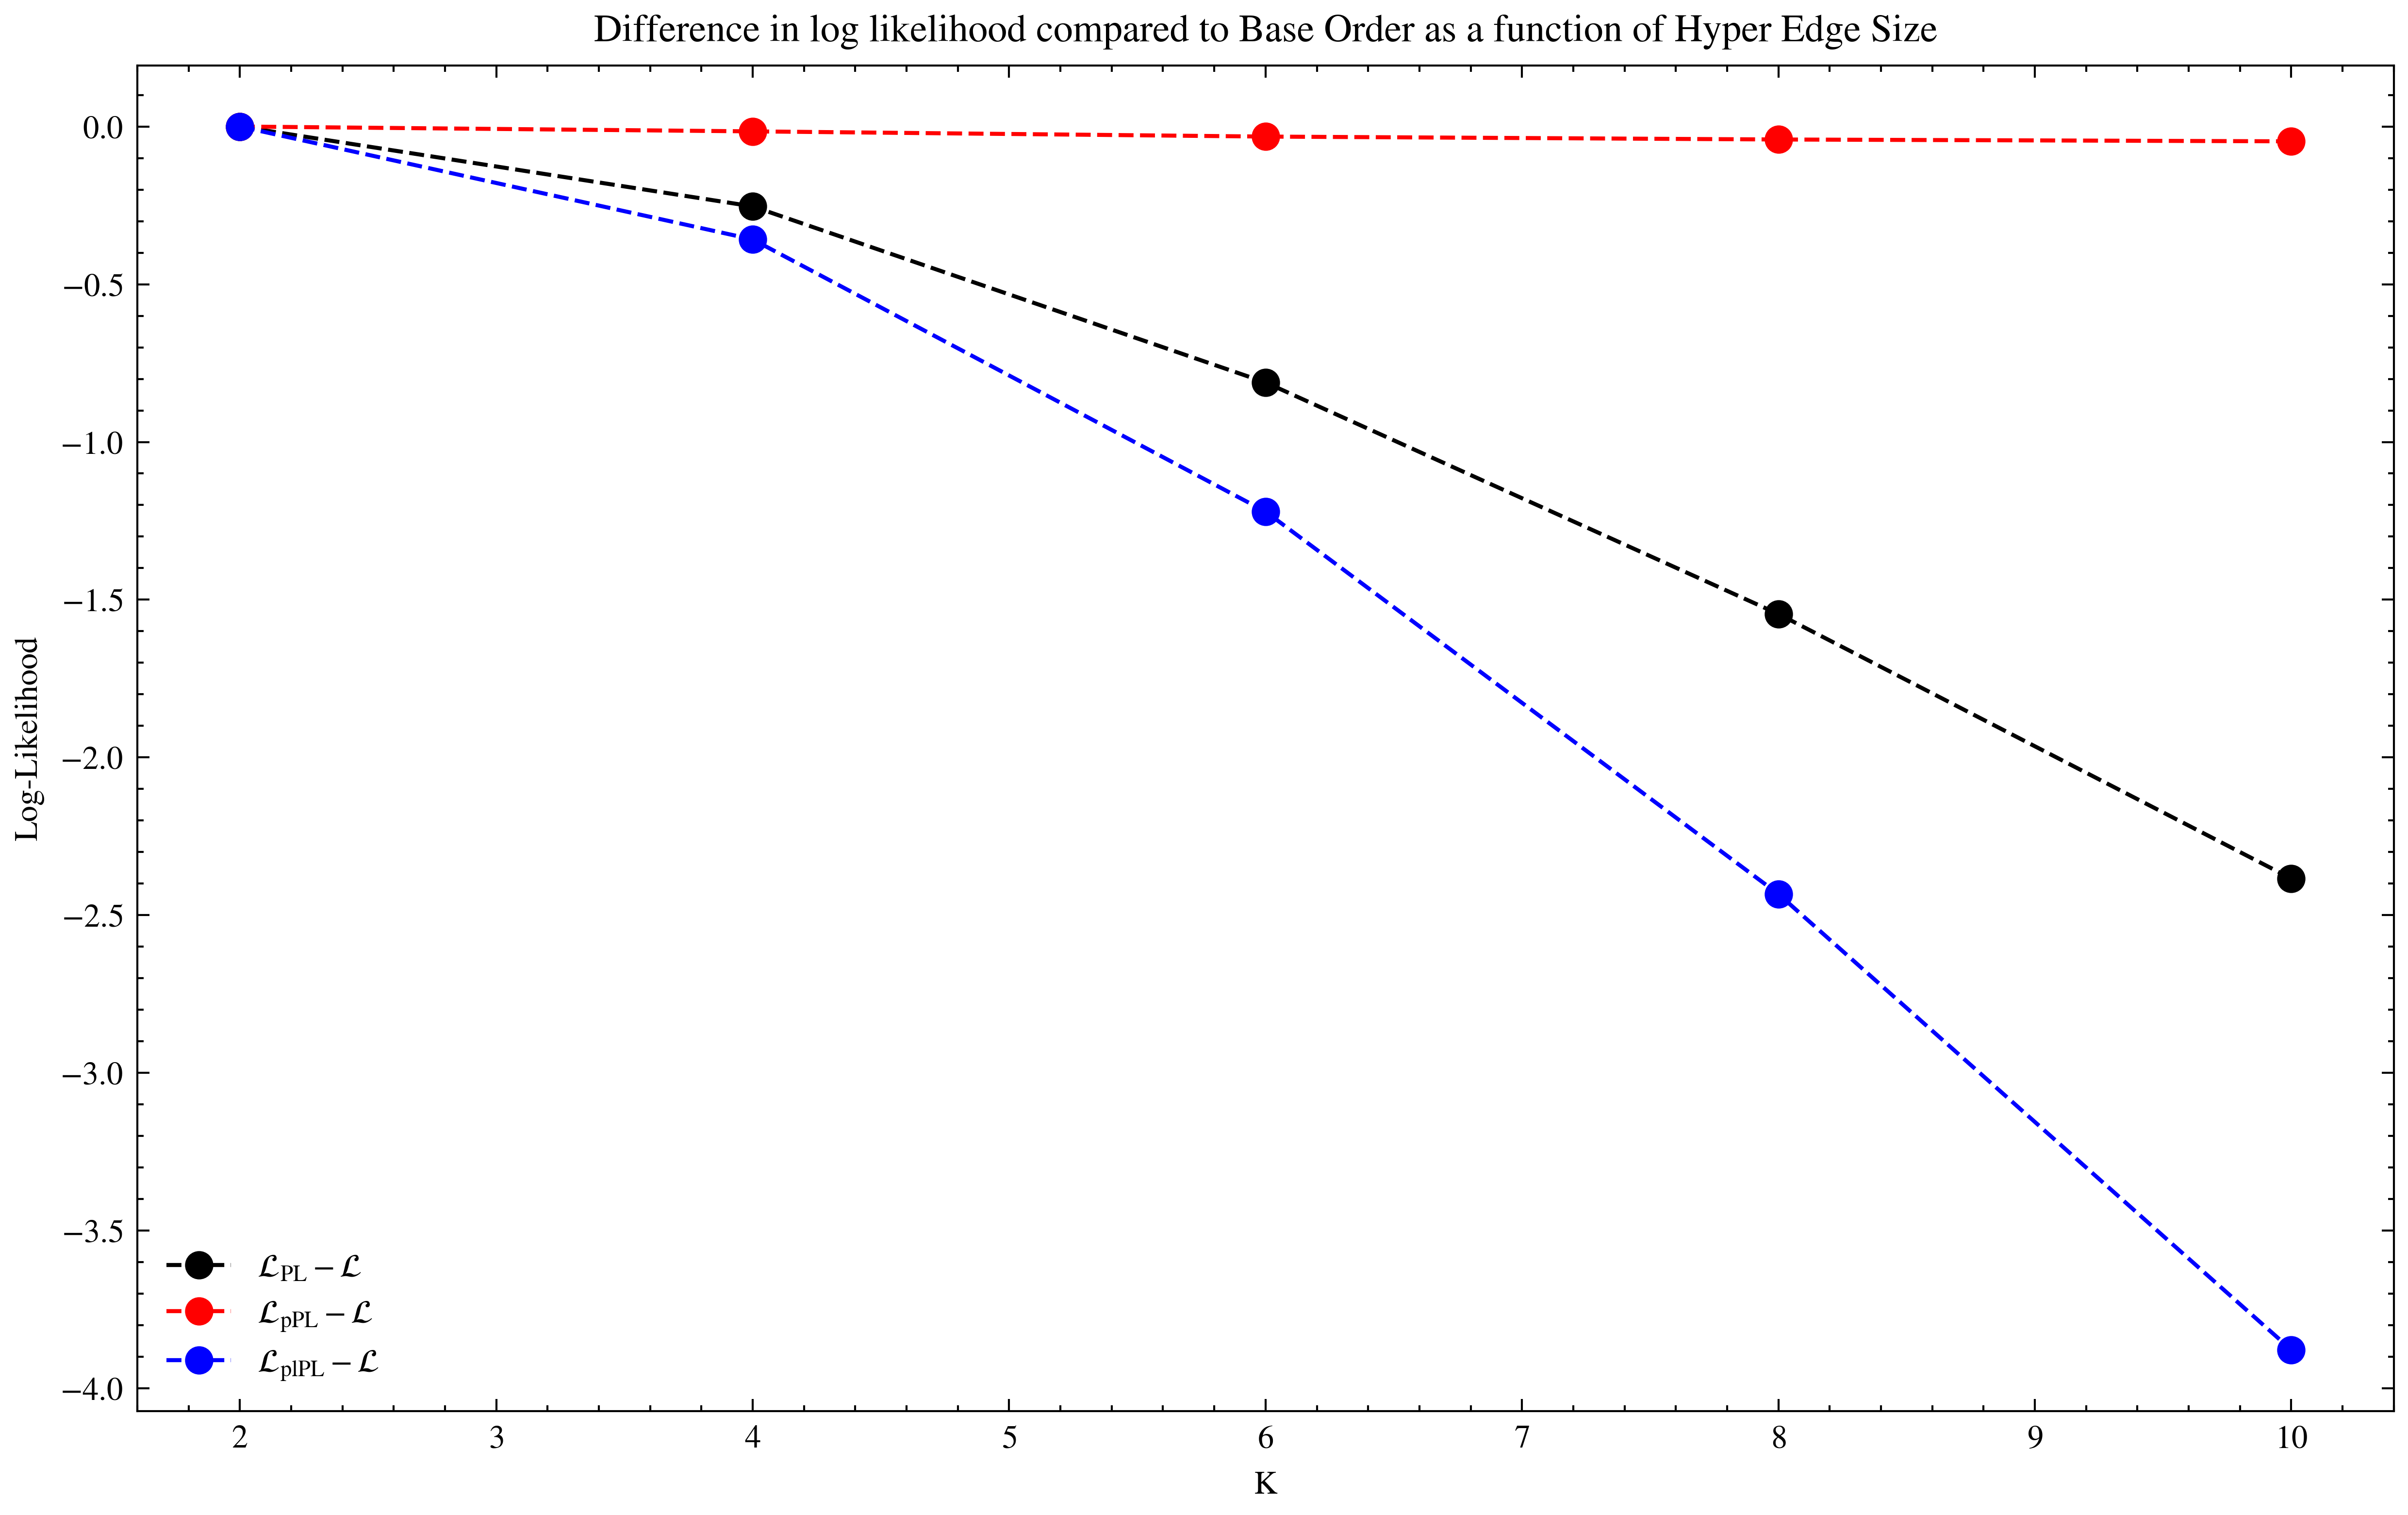

In [7]:
ho_df = main[(main['L'] == 0.0)]
grouped = main.groupby(by=['K']).mean().reset_index()

plt.figure(figsize=(10,6))
plt.title('Difference in log likelihood compared to Base Order as a function of Hyper Edge Size')
# plt.plot(grouped['K'], grouped['HO_BT'], marker='o', linestyle = '--', label='HO')
plt.plot(grouped['K'], grouped['HOL_BT'] -grouped['HO_BT'], marker=MARKERS['HO_BT'], linestyle = '--', label='$\\mathcal{L}_{\\text{PL}} - \\mathcal{L}$')
plt.plot(grouped['K'], grouped['BIN'] - grouped['HO_BT'], marker=MARKERS['BIN'], linestyle = '--', label='$\\mathcal{L}_{\\text{pPL}} - \\mathcal{L}$')
plt.plot(grouped['K'], grouped['BINL'] - grouped['HO_BT'], marker=MARKERS['HO_BT'], linestyle = '--', label='$\\mathcal{L}_{\\text{plPL}} - \\mathcal{L}$')
plt.xlabel('K')
plt.ylabel('Log-Likelihood')
plt.legend()

In [8]:
C_PATH = os.path.abspath(os.path.join(repo_root, 'C_Prog'))

def run_simulation_comparison(filein_idx, filein_data, ratio=.8, is_synthetic=0):

    command = os.path.join(C_PATH, 'Readfile', 'bt_model_data.out') + ' ' + filein_idx + ' ' + filein_data + ' ' +  str(ratio) + ' ' + str(is_synthetic)
    # print(shlex.split(command))

    process = subprocess.Popen(shlex.split(command), stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    
    ##parse output
    output = process.communicate()[0].decode("utf-8")
    # print(output)

    G, HO, HOL, BIN, BINL = output.split(';;;') 


    G = G.split()
    HO = HO.split()
    HOL = HOL.split()
    BIN = BIN.split()
    BINL = BINL.split()
    # model log likelihood, model leadership likelihood, ho log likelihood, bin log likelihood, HOL leadership log likelihood, BINL Leadership log likelihood 
    return [float(G[-3]), float(G[-2]), float(HO[4]), float(BIN[4]), float(HOL[5]), float(BINL[5])]

In [9]:


data_dir = os.path.join(repo_root, 'datasets', 'Real_Data')

grouped = group_dataset_files(data_dir)

edge_file = grouped['00009']['edges']
node_file = grouped['00009']['nodes']
edge_path = os.path.join(data_dir, edge_file)

ho_like = []
binho_like = []
bin_vs_ho_like = []
hol_like = []
binhol_like = []
bin_vs_hol_like = []
node_path = os.path.join(data_dir, node_file)

T = 100
for t in range(T):
    print(f"\rProcessing epoch: {t}", end='', flush=True)
    results = run_simulation_comparison(node_path, edge_path, .8, 1)

    ho_like.append(results[2] - results[0])
    binho_like.append(results[3] - results[0])
    bin_vs_ho_like.append(results[3] - results[2])

    hol_like.append(results[4] - results[1])
    binhol_like.append(results[5] - results[1])
    bin_vs_hol_like.append(results[5] - results[4])


Processing epoch: 0

Processing epoch: 99

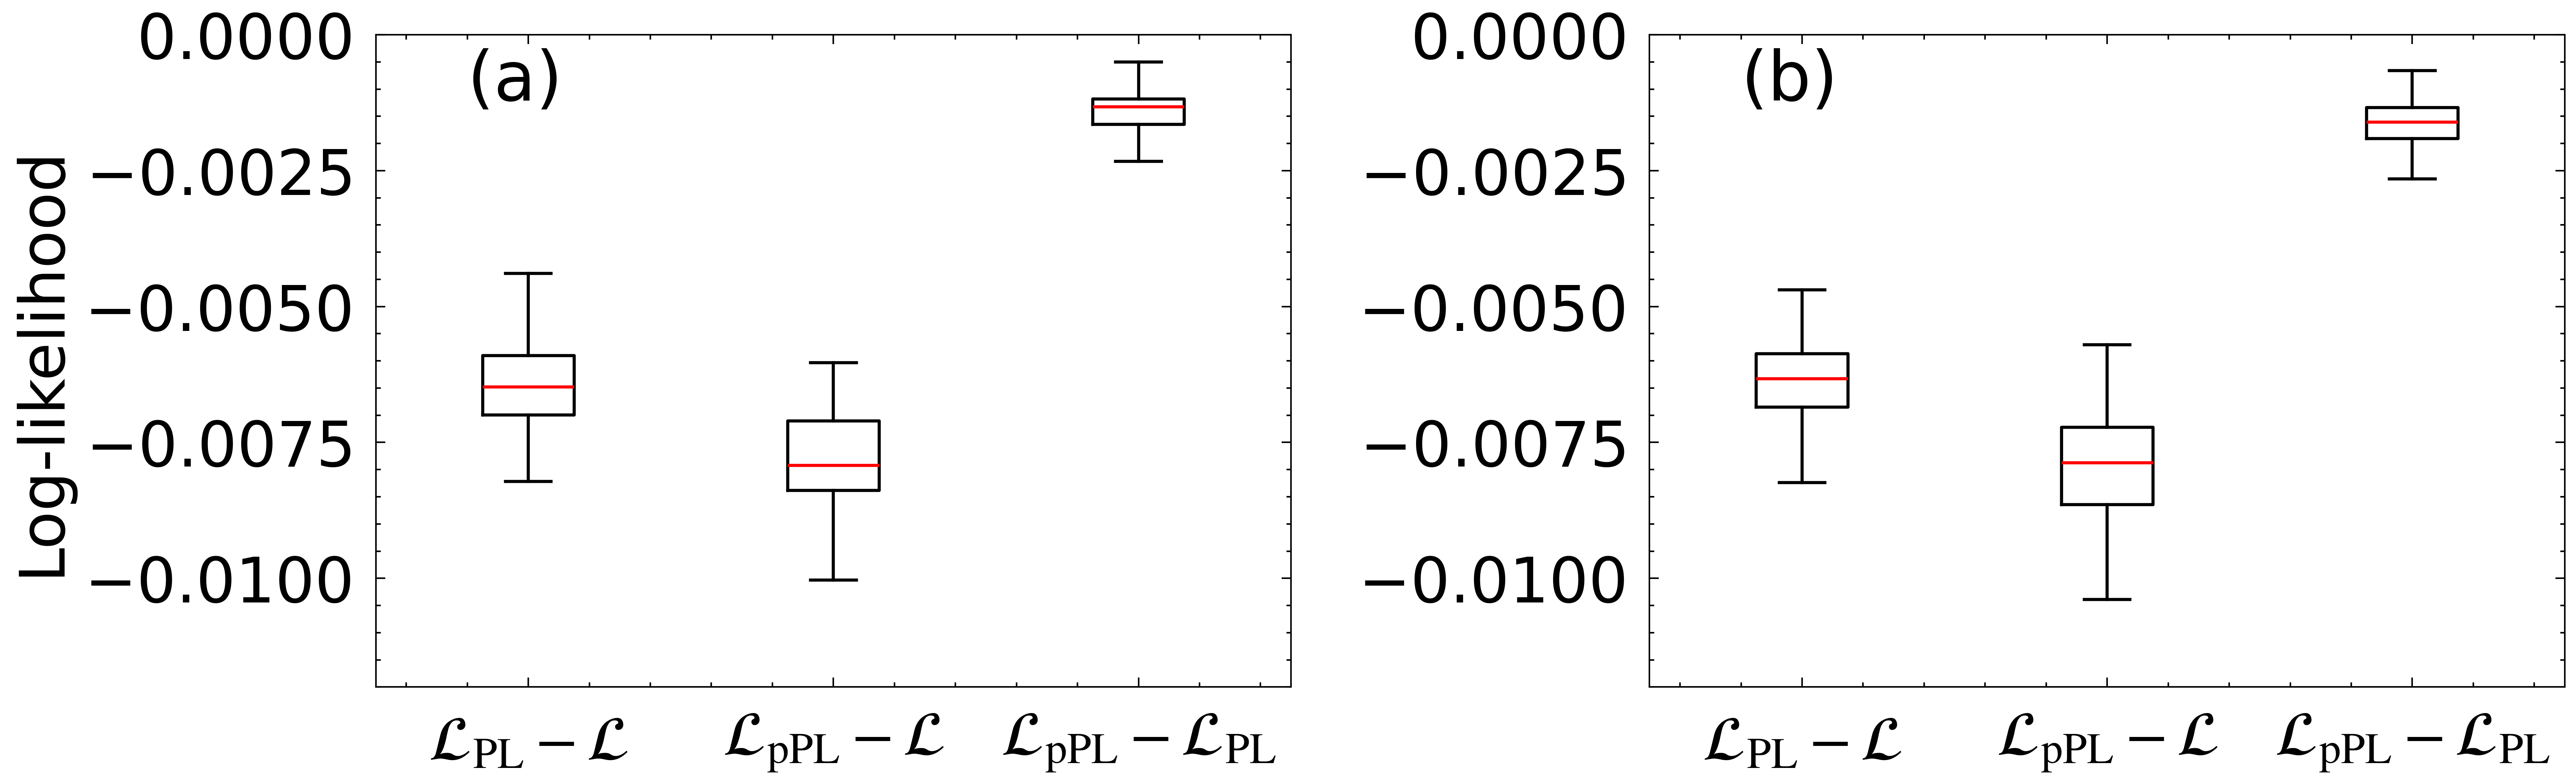

In [11]:
fig = plt.figure(figsize=(12, 4))

plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)




ax1.boxplot([ho_like, binho_like, bin_vs_ho_like], showfliers=False)
ax2.boxplot([hol_like, binhol_like, bin_vs_hol_like], showfliers=False)


# ax1.axhline(y=1e-6, linestyle='dashed', color = 'black')
ax1.set_ylim(-0.012, 0.0)
ax2.set_ylim(-0.012, 0.0)

ax1.set_xticklabels(['$\\mathcal{L}_{\\text{PL}} - \\mathcal{L}$', '$\\mathcal{L}_{\\text{pPL}} - \\mathcal{L}$', '$\\mathcal{L}_{\\text{pPL}} - \\mathcal{L}_{\\text{PL}}$'])
ax2.set_xticklabels(['$\\mathcal{L}_{\\text{PL}} - \\mathcal{L}$', '$\\mathcal{L}_{\\text{pPL}} - \\mathcal{L}$', '$\\mathcal{L}_{\\text{pPL}} - \\mathcal{L}_{\\text{PL}}$'])
ax1.set_ylabel('Log-likelihood')


fig.text(0.1, 0.9, '(a)', transform=ax1.transAxes, fontsize=22)
fig.text(0.1, 0.9, '(b)', transform=ax2.transAxes, fontsize=22)

fig.tight_layout()
plt.show()